# 노이즈 제거 확산 암시적 모델 (Denoising Diffusion Implicit Models)

**저자:** [András Béres](https://www.linkedin.com/in/andras-beres-789190210)  
**생성일:** 2022/06/24  
**최종편집일:** 2022/06/24  
**설명:** 노이즈 제거 확산 암묵적 모델을 사용하여 꽃 이미지를 생성합니다.

## 소개

최근, [점수 기반 생성 모델(score-based generative models)](https://arxiv.org/abs/1907.05600)을 포함한 [노이즈 제거 확산 모델(denoising diffusion models)](https://arxiv.org/abs/2006.11239)이 강력한 생성 모델 클래스로 인기를 얻었으며, 이미지 합성 품질에서 [생성적 적대 신경망(GAN)](https://arxiv.org/abs/1406.2661)과도 [경쟁](https://arxiv.org/abs/2105.05233)할 수 있습니다. 이러한 모델은 안정적으로 트레이닝하고 확장하기 쉬운 반면, 더 다양한 샘플을 생성하는 경향이 있습니다. ([DALL-E 2](https://openai.com/dall-e-2/) 및 [Imagen](https://imagen.research.google/)과 같은) 최근의 대규모 확산 모델은, 놀라운 텍스트-이미지(text-to-image) 생성 기능을 보여주었습니다. 그러나 단점 중 하나는, 이미지를 생성하기 위해 여러 차례의 전방 패스(forward passes)가 필요하기 때문에, 샘플링 속도가 느리다는 것입니다.

확산은 구조화된 신호(이미지)를 단계적으로 노이즈로 변환하는 프로세스를 말합니다. 확산을 시뮬레이션하면, 트레이닝 이미지에서 노이즈가 있는 이미지를 생성하고, 신경망을 트레이닝하여 노이즈를 제거하려고 할 수 있습니다. 트레이닝된 네트워크를 사용하면, 확산(diffusion)의 반대인 역확산(reverse diffusion)을 시뮬레이션할 수 있습니다. 역확산은 노이즈에서 이미지가 나오는 프로세스입니다.

![diffusion process gif](https://i.imgur.com/dipPOfa.gif)

한 문장 요약: **확산(diffusion) 모델은 노이즈가 있는 이미지의 노이즈를 제거하도록 트레이닝되며, 순수한 노이즈를 반복적으로 제거하여 이미지를 생성할 수 있습니다.**

### 이 예제의 목표

이 코드 예제는, 적당한 컴퓨팅 요구 사항과 적절한 성능을 갖춘, 확산 모델의 최소이지만 (생성 품질 메트릭으로) 기능은 완전한 구현을 목표로 합니다. 이러한 목표를 염두에 두고, 구현 선택과 하이퍼파라미터 튜닝을 수행했습니다.

현재 확산 모델에 대한 문헌은 [수학적으로 매우 복잡](https://arxiv.org/abs/2206.00364)하고, 여러 이론적 프레임워크([점수 매칭](https://arxiv.org/abs/1907.05600), [미분 방정식](https://arxiv.org/abs/2011.13456), [마르코프 체인](https://arxiv.org/abs/2006.11239)) 및 때로는 [상충되는 표기법(부록 C.2 참조)](https://arxiv.org/abs/2010.02502)이 있기 때문에, 이를 이해하려고 하면 어려울 수 있습니다. 제가 보기에 이 예에서 이 모델은 노이즈가 있는 이미지를 이미지와 가우시안 노이즈 구성요소로 분리하는 법을 배웠습니다.

이 예에서 저는 모든 긴 수학적 표현식을 소화하기 쉬운 조각으로 분해하고, 모든 변수에 설명적 이름을 부여하려고 노력했습니다. 또한 관심 있는 독자가 주제에 더 깊이 파고들 수 있도록, 관련 문헌에 대한 수많은 링크를 포함했으며, 이 코드 예가 ​​확산 모델을 배우는 실무자에게 좋은 시작점이 되기를 바랍니다.

다음 섹션에서는, 결정적 샘플링(deterministic sampling)을 사용하여, [Denoising Diffusion Implicit Models(DDIMs)](https://arxiv.org/abs/2010.02502)의 연속 시간 버전을 구현합니다.

## 셋업

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

import keras
from keras import layers
from keras import ops

## 하이퍼파라미터

In [9]:
# data
dataset_name = "oxford_flowers102"
dataset_repetitions = 5
# num_epochs = 1  # 좋은 결과를 얻으려면 최소 50 에포크 이상 트레이닝하세요.
num_epochs = 50
image_size = 64
# KID = Kernel Inception Distance (커널 시작 거리), 관련 섹션 참조
kid_image_size = 75
kid_diffusion_steps = 5
plot_diffusion_steps = 20

# 샘플링
min_signal_rate = 0.02
max_signal_rate = 0.95

# 아키텍처
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# 최적화
batch_size = 64
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

## 데이터 파이프라인

우리는 꽃 이미지를 생성하기 위해 [Oxford Flowers 102](https://www.tensorflow.org/datasets/catalog/oxford_flowers102) 데이터 세트를 사용할 것입니다. 이는 약 8,000개의 이미지가 포함된 다양한 자연 데이터 세트입니다. 불행히도 공식 분할은 불균형합니다. 대부분의 이미지가 테스트 분할에 포함되어 있기 때문입니다. 우리는 [Tensorflow Datasets 슬라이싱 API](https://www.tensorflow.org/datasets/splits)를 사용하여 새로운 분할(80%는 트레이닝, 20%는 검증)을 만듭니다. 우리는 전처리로 중앙 자르기(center crops)를 적용하고, 데이터 세트를 여러 번 반복합니다. (이유는 다음 섹션에 나와 있습니다)

In [3]:
def preprocess_image(data):
    # 이미지 중앙 자르기(center crop)
    height = ops.shape(data["image"])[0]
    width = ops.shape(data["image"])[1]
    crop_size = ops.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    # 크기 조절 및 클립(clip)
    # 이미지 다운샘플링을 위해서는 앤티앨리어싱을 켜는 것이 중요합니다.
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    return ops.clip(image / 255.0, 0.0, 1.0)


def prepare_dataset(split):
    # KID 추정에 데이터 순서가 중요하기(data order matters) 때문에,
    # 검증 데이터 세트도 셔플합니다.
    return (
        tfds.load(dataset_name, split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .repeat(dataset_repetitions)
        .shuffle(10 * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )


# 데이터 세트 로드
train_dataset = prepare_dataset("train[:80%]+validation[:80%]+test[:80%]")
val_dataset = prepare_dataset("train[80%:]+validation[80%:]+test[80%:]")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteBM8KLO/oxford_flowers102-train.tfrecord*…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteBM8KLO/oxford_flowers102-test.tfrecord*.…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteBM8KLO/oxford_flowers102-validation.tfre…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


## Kernel Inception Distance (KID, 커널 시작 거리)

[Kernel Inception Distance(KID)](https://arxiv.org/abs/1801.01401)는 인기 있는 [Frechet Inception Distance(FID)](https://arxiv.org/abs/1706.08500)를 대체하기 위해 제안된 이미지 품질 메트릭입니다. 구현이 더 간단하고, 배치별로 추정할 수 있으며, 계산이 더 가볍기 때문에, FID보다 KID를 선호합니다. 자세한 내용은 [여기](https://codecompose7.github.io/keras-doc-kr.github.io/examples/generative/gan_ada/#kernel-inception-distance)에서 확인하세요.

이 예에서, 이미지는 Inception 네트워크의 최소 가능한 해상도(299x299 대신 75x75)에서 평가되고, 메트릭은 계산 효율성을 위해 검증 세트에서만 측정됩니다. 또한 같은 이유로 평가 시 샘플링 단계 수를 5로 제한합니다.

데이터 세트가 비교적 작기 때문에, 한 에포크당 여러 번 트레이닝 및 검증 분할을 수행합니다. KID 추정에는 노이즈가 많고, 계산 집약적이기 때문에, 여러 반복 후에만 평가하고 싶습니다.

In [4]:
@keras.saving.register_keras_serializable()
class KID(keras.metrics.Metric):
    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID는 배치별로 추정되며, 배치 전체에 걸쳐 평균화됩니다.
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # 사전 트레이닝된 InceptionV3는 분류 레이어 없이 사용되며,
        # 픽셀 값을 0-255 범위로 변환한 다음, 사전 트레이닝 중과 동일한 사전 처리를 사용합니다.
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = ops.cast(ops.shape(features_1)[1], dtype="float32")
        return (
            features_1 @ ops.transpose(features_2) / feature_dimensions + 1.0
        ) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # 두 개의 특성 세트를 사용하여 다항식 커널(polynomial kernels)을 계산합니다.
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # 평균 커널 값을 사용하여, 제곱 최대 평균 불일치(squared maximum mean discrepancy)를 추정합니다.
        batch_size = real_features.shape[0]
        batch_size_f = ops.cast(batch_size, dtype="float32")
        mean_kernel_real = ops.sum(kernel_real * (1.0 - ops.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = ops.sum(
            kernel_generated * (1.0 - ops.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = ops.mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # 평균 KID 추정치 업데이트
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()

## 네트워크 아키텍쳐

여기서 우리는 노이즈 제거에 사용할 신경망의 아키텍처를 지정합니다.
우리는 동일한 입력 및 출력 차원을 가진 [U-Net](https://arxiv.org/abs/1505.04597)을 빌드합니다.
U-Net은 인기 있는 시맨틱 세그멘테이션 아키텍처로, 주요 아이디어는 입력 이미지를 점진적으로 다운샘플링한 다음 업샘플링하고 동일한 해상도를 가진 레이어 간에 스킵 연결을 추가하는 것입니다.
이는 일반적인 [자동 인코더](https://www.deeplearningbook.org/contents/autoencoders.html)와 달리 그래디언트 흐름을 돕고 표현 병목 현상을 방지합니다.
이를 기반으로, 병목 현상 없이 [확산 모델을 노이즈 제거 자동 인코더](https://benanne.github.io/2022/01/31/diffusion.html)로 볼 수 있습니다.

네트워크는 (1) 노이즈가 있는 이미지와 (2) 노이즈 구성 요소의 분산이라는 두 가지 입력을 받습니다.
후자는 신호의 노이즈 제거에 다양한 레벨의 노이즈에서 다양한 작업이 필요하기 때문에 필요합니다.
우리는 [트랜스포머](https://arxiv.org/abs/1706.03762)와 [NeRF](https://arxiv.org/abs/2003.08934)에서 모두 사용되는 위치 인코딩과 유사하게, 사인파 임베딩을 사용하여 노이즈 분산을 변환합니다.
이를 통해, 네트워크가 노이즈 레벨에 [매우 민감하게](https://arxiv.org/abs/2006.10739) 되는데,
이는 우수한 성능에 필수적입니다.
우리는 [람다 레이어](https://codecompose7.github.io/keras-doc-kr.github.io/api/layers/core_layers/lambda/)를 사용하여,
사인파 임베딩을 구현합니다.

다른 고려 사항:

* [Keras Functional API]({{ site.baseurl }}/guides/functional_api/)를 사용하여 네트워크를 빌드하고, [closures](https://twitter.com/fchollet/status/1441927912836321280)를 사용하여, 일관된 스타일로 레이어 블록을 구축합니다.
* [확산 모델](https://arxiv.org/abs/2006.11239)은 노이즈 분산 대신 확산 프로세스의 타임스텝 인덱스를 임베드하는 반면, [점수 기반 모델 (표 1)](https://arxiv.org/abs/2206.00364)은 일반적으로 노이즈 레벨의 일부 함수를 사용합니다. 저는 후자를 선호하는데, 네트워크를 다시 학습시키지 않고도, 추론 시간에 샘플링 스케쥴을 변경할 수 있기 때문입니다.
* [확산 모델](https://arxiv.org/abs/2006.11239)은 각 컨볼루션 블록에 임베딩을 별도로 입력합니다. 단순성을 위해 네트워크 시작 시에만 입력하는데, 제 경험상 스킵 및 residual 연결이 정보가 네트워크를 통해 적절하게 전파되도록 돕기 때문에, 성능이 거의 저하되지 않습니다.
* 문헌에서는 더 나은 전역적 코히어런스(global coherence)를 위해, 낮은 해상도에서 [어텐션 레이어](https://codecompose7.github.io/keras-doc-kr.github.io/api/layers/attention_layers/multi_head_attention/)를 사용하는 것이 일반적입니다. 단순성을 위해 생략했습니다.
* 다음 컨볼루션 레이어가 중복되기 때문에, 배치 정규화 레이어의 학습 가능한 중심 및 스케일 매개변수를 비활성화합니다.
* 좋은 관행으로 마지막 컨볼루션의 커널을 모두 0으로 초기화하여, 네트워크가 초기화 후에 대상의 평균인 0만 예측하도록 합니다. 이렇게 하면 트레이닝 시작 시 동작이 개선되고, 평균 제곱 오차 손실이 정확히 1에서 시작됩니다.

In [5]:
@keras.saving.register_keras_serializable()
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = ops.exp(
        ops.linspace(
            ops.log(embedding_min_frequency),
            ops.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = ops.cast(2.0 * math.pi * frequencies, "float32")
    embeddings = ops.concatenate(
        [ops.sin(angular_speeds * x), ops.cos(angular_speeds * x)], axis=3
    )
    return embeddings


def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same", activation="swish")(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply


def get_network(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding, output_shape=(1, 1, 32))(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet")

이는 Functional API의 힘을 보여줍니다. 80줄의 코드로 스킵 연결, residual 블록, 다중 입력 및 사인파 임베딩을 사용하여 비교적 복잡한 U-Net을 구축한 방법에 주목하세요!

## 확산 모델 (Diffusion model)

### 확산 스케쥴

확산 과정이 time = 0에서 시작하여 time = 1에서 끝난다고 가정해 보겠습니다.
이 변수는 확산 시간(diffusion time)이라고 하며, 이산적(확산 모델에서 일반적)이거나
연속적(점수 기반 모델에서 일반적)일 수 있습니다.
저는 후자를 선택하여, 추론 시간에 샘플링 단계 수를 변경할 수 있도록 했습니다.

확산 과정의 각 지점에서, 실제 확산 시간에 해당하는 노이즈 이미지의 노이즈 레벨과 신호 레벨을 알려주는, 함수가 필요합니다.
이를 확산 스케줄(diffusion schedule)이라고 합니다. (`diffusion_schedule()` 참조)

이 스케줄은 두 가지 양을 출력합니다. `noise_rate`와 `signal_rate`(각각 DDIM 논문의 sqrt(1 - alpha)와 sqrt(alpha)에 해당).
랜덤 노이즈와 트레이닝 이미지에 해당 비율로 가중치를 부여하고, 이를 더하여 노이즈 이미지를 생성합니다.

(표준 정규) 랜덤 노이즈와 (정규화된) 이미지는 모두 평균이 0이고 유닛 분산이므로,
노이즈 비율과 신호 비율은 노이즈가 있는 이미지의 구성 요소의 표준 편차로 해석할 수 있고,
그들의 비율의 제곱은 분산(또는 신호 처리 의미에서의 전력)으로 해석할 수 있습니다.
비율은 항상 제곱 합이 1이 되도록 설정되므로,
노이즈가 있는 이미지는 항상, 스케일되지 않은 구성 요소(unscaled components)와 마찬가지로,
유닛 분산을 갖습니다.

우리는 문헌에서 꽤 일반적으로 사용되는 [코사인 스케줄(섹션 3.2)](https://arxiv.org/abs/2102.09672)의 단순화된 연속 버전을 사용할 것입니다.
이 스케쥴은 대칭적(symmetric)이고, 확산 과정의 시작과 끝 부분에서 느리며,
[유닛 원의 삼각법 속성](https://en.wikipedia.org/wiki/Unit_circle#/media/File:Circle-trig6.svg)을 사용하여, 훌륭한 기하학적 해석도 제공합니다.

![diffusion schedule gif](https://i.imgur.com/JW9W0fA.gif)


### 트레이닝 과정

노이즈 제거 확산 모델의 트레이닝 절차(`train_step()` 및 `denoise()` 참조)는 다음과 같습니다.
랜덤 확산 시간을 균일하게 샘플링하고,
확산 시간에 해당하는 비율로 랜덤 가우시안 노이즈와 트레이닝 이미지를 혼합합니다.
그런 다음, 노이즈가 있는 이미지를 두 구성 요소로 분리하도록 모델을 트레이닝합니다.

일반적으로, 신경망은 스케일링되지 않은 노이즈 구성 요소를 예측하도록 트레이닝되며,
여기서 예측된 이미지 구성 요소는 신호 및 노이즈 비율을 사용하여 계산할 수 있습니다.
픽셀별 [평균 제곱 오차](https://codecompose7.github.io/keras-doc-kr.github.io/api/losses/regression_losses/#mean_squared_error-function)를 이론적으로 사용해야 하지만,
저는 대신 [평균 절대 오차](https://codecompose7.github.io/keras-doc-kr.github.io/api/losses/regression_losses/#mean_absolute_error-function)를 사용하는 것을 권장합니다. (이 구현과 유사)
이렇게 하면, 이 데이터 세트에서 더 나은 결과를 얻을 수 있습니다.

### 샘플링 (역확산)

샘플링(`reverse_diffusion()` 참조)할 때,
각 단계에서 우리는 노이즈가 있는 이미지의 이전 추정치를 가져와,
네트워크를 사용하여 이미지와 노이즈로 분리합니다.
그런 다음, 다음 단계의 신호 및 노이즈 비율을 사용하여, 이러한 구성 요소를 다시 결합합니다.

[DDIM의 수식 12](https://arxiv.org/abs/2010.02502)에 유사한 보기가 나와 있지만,
위의 샘플링 수식에 대한 설명은 널리 알려지지 않은 것으로 생각합니다.

이 예는, 논문에서 _eta = 0_ 에 해당하는 DDIM의 결정적 샘플링 절차만 구현합니다.
확률적 샘플링을 사용할 수도 있습니다. (이 경우 모델은 [Denoising Diffusion Probabilistic Model(DDPM)](https://arxiv.org/abs/2006.11239)이 됨)
예측된 노이즈의 일부가 동일하거나, 더 많은 양의 랜덤 노이즈로 대체됩니다. ([아래 수식 16 참조](https://arxiv.org/abs/2010.02502))

확률적 샘플링(Stochastic sampling)은 네트워크를 다시 트레이닝하지 않고도 사용할 수 있으며 (두 모델 모두 동일한 방식으로 트레이닝되기 때문), 샘플 품질을 개선할 수 있지만, 일반적으로 더 많은 샘플링 단계가 필요합니다.

In [6]:
@keras.saving.register_keras_serializable()
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = get_network(image_size, widths, block_depth)
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        self.kid = KID(name="kid")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def denormalize(self, images):
        # 픽셀 값을 0-1 범위로 다시 변환합니다.
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return ops.clip(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # 확산 시간 -> 각도
        start_angle = ops.cast(ops.arccos(max_signal_rate), "float32")
        end_angle = ops.cast(ops.arccos(min_signal_rate), "float32")

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # 각도 -> 신호 및 노이즈 비율
        signal_rates = ops.cos(diffusion_angles)
        noise_rates = ops.sin(diffusion_angles)
        # 그들의 제곱 합은 항상 sin^2(x) + cos^2(x) = 1이라는 점에 유의하세요.

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # 지수 이동 평균 가중치(exponential moving average weights)는 평가에 사용됩니다.
        if training:
            network = self.network
        else:
            network = self.ema_network

        # 노이즈 성분을 예측하고, 이를 이용하여 이미지 성분을 계산합니다.
        pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # 역확산 = 샘플링
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # 중요 라인:
        # 첫 번째 샘플링 단계에서, "노이즈 이미지"는 순수한 노이즈이지만,
        # 신호 비율은 0이 아닌 것으로 가정합니다. (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # 현재 노이즈가 있는 이미지를 구성 요소로 분리합니다.
            diffusion_times = ops.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            # 평가 모드에서 사용되는 네트워크

            # 다음 신호 및 노이즈 비율을 사용하여, 예측된 구성 요소를 리믹스합니다.
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # 이 새로운 노이즈 이미지는 다음 단계에서 사용될 것입니다.

        return pred_images

    def generate(self, num_images, diffusion_steps):
        # 노이즈 -> 이미지 -> 비정규화된 이미지
        initial_noise = keras.random.normal(
            shape=(num_images, image_size, image_size, 3)
        )
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        # 노이즈와 같이, 표준 편차가 1이 되도록 이미지를 정규화합니다.
        images = self.normalizer(images, training=True)
        noises = keras.random.normal(shape=(batch_size, image_size, image_size, 3))

        # 샘플 균일 무작위 확산 시간
        diffusion_times = keras.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # 이미지와 노이즈를 적절히 섞습니다.
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # 노이즈가 있는 이미지를 구성 요소로 분리하도록 네트워크를 트레이닝합니다.
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # 트레이닝에 사용됨
            image_loss = self.loss(images, pred_images)  # 메트릭으로만 사용됨

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # 가중치의 지수 이동 평균(exponential moving averages)을 추적합니다.
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID는, 계산 효율성을 위해, 트레이닝 단계에서는 측정되지 않습니다.
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, images):
        # 노이즈와 같이 표준 편차가 1이 되도록 이미지를 정규화합니다.
        images = self.normalizer(images, training=False)
        noises = keras.random.normal(shape=(batch_size, image_size, image_size, 3))

        # 샘플 균일 무작위 확산 시간
        diffusion_times = keras.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # 이미지와 노이즈를 적절히 섞습니다.
        noisy_images = signal_rates * images + noise_rates * noises

        # 네트워크를 사용하여 노이즈가 있는 이미지를 구성 요소로 분리합니다.
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        # 실제 이미지와 생성된 이미지 사이의 KID를 측정합니다.
        # 이는 계산적으로 까다로우며, kid_diffusion_steps는 작아야 합니다.
        images = self.denormalize(images)
        generated_images = self.generate(
            num_images=batch_size, diffusion_steps=kid_diffusion_steps
        )
        self.kid.update_state(images, generated_images)

        return {m.name: m.result() for m in self.metrics}

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6):
        # 생성 품질의 시각적 평가를 위해, 무작위로 생성된 이미지를 플롯합니다.
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
        )

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()

## 트레이닝

In [10]:
# 모델을 생성하고 컴파일합니다.
model = DiffusionModel(image_size, widths, block_depth)
# tensorflow 2.9 이하:
# pip install tensorflow_addons
# import tensorflow_addons as tfa
# optimizer=tfa.optimizers.AdamW
model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
# 픽셀 단위 평균 절대 오차는 손실로 사용됩니다.

# 검증 KID 메트릭을 기반으로 최상의 모델을 저장합니다.
checkpoint_path = "checkpoints/diffusion_model.weights.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)

# 정규화를 위한 트레이닝 데이터 세트의 평균과 분산을 계산합니다.
model.normalizer.adapt(train_dataset)

# 주기적으로 트레이닝을 실행하고, 생성된 이미지를 플롯합니다.
model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        checkpoint_callback,
    ],
)

Output hidden; open in https://colab.research.google.com to view.

## 추론

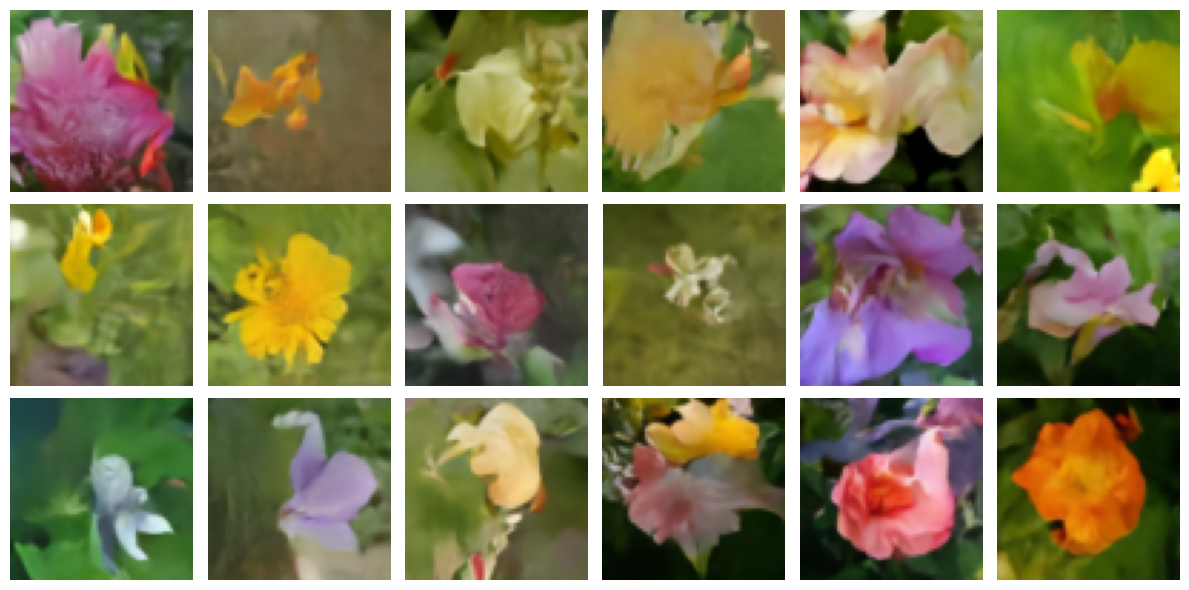

In [11]:
# 최상의 모델을 로드하고 이미지를 생성합니다.
model.load_weights(checkpoint_path)
model.plot_images()

## 결과

최소 50에포크 동안 트레이닝을 실행하면(T4 GPU에서는 2시간, A100 GPU에서는 30분 소요),
이 코드 예제를 사용하여 고품질 이미지 생성을 얻을 수 있습니다.

80에포크 트레이닝을 통한 이미지 배치의 진화(색상 아티팩트는 GIF 압축으로 인해 발생):

![flowers training gif](https://i.imgur.com/FSCKtZq.gif)

동일한 초기 노이즈에서 1~20 샘플링 단계를 사용하여 생성된 이미지:

![flowers sampling steps gif](https://i.imgur.com/tM5LyH3.gif)

초기 노이즈 샘플 간 보간(구형) (Interpolation (spherical)):

![flowers interpolation gif](https://i.imgur.com/hk5Hd5o.gif)

결정론적(Deterministic) 샘플링 프로세스(위쪽은 노이즈가 있는 이미지, 아래쪽은 예측된 이미지, 40단계):

![flowers deterministic generation gif](https://i.imgur.com/wCvzynh.gif)

확률적(Stochastic) 샘플링 프로세스(위쪽은 노이즈가 있는 이미지, 아래쪽은 예측된 이미지, 80단계):

![flowers stochastic generation gif](https://i.imgur.com/kRXOGzd.gif)

## 배운 교훈

이 코드 예제를 준비하는 동안, [이 저장소](https://github.com/beresandras/clear-diffusion-keras)를 사용하여 수많은 실험을 했습니다.
이 섹션에서는 배운 교훈과 제 권장 사항을 주관적인 중요도 순서대로 나열합니다.

### 알고리즘 팁

* **최소 및 최대 신호 비율**: 최소 신호 비율이 중요한 하이퍼파라미터라는 것을 알았습니다.
  너무 낮게 설정하면 생성된 이미지가 과포화(oversaturated)되고,
  너무 높게 설정하면 불포화(undersaturated)됩니다. 신중하게 조정하는 것이 좋습니다.
  또한 0으로 설정하면, 0으로 나누는 오류가 발생합니다.
  최대 신호 비율은 1로 설정할 수 있지만, 더 낮게 설정하면 생성 품질이 약간 향상되는 것을 발견했습니다.
* **손실 함수**: 대형 모델은 평균 제곱 오차(MSE) 손실을 사용하는 경향이 있지만,
  이 데이터 세트에서는 평균 절대 오차(MAE)를 사용하는 것이 좋습니다.
  제 경험상 MSE 손실은 더 다양한 샘플을 생성하는 반면,
  (또한 더 많은 환각(hallucinate)을 보는 것 같습니다. [섹션 3](https://arxiv.org/abs/2111.05826))
  MAE 손실은 더 부드러운 이미지를 생성합니다. 둘 다 시도해 보는 것이 좋습니다.
* **가중치 감쇠(weight decay)**: 모델을 확장할 때 가끔 발산된 트레이닝에 부딪혔고,
  가중치 감쇠가 낮은 성능 비용으로 불안정성을 피하는 데 도움이 된다는 것을 발견했습니다.
  이것이 이 예에서 [Adam](https://codecompose7.github.io/keras-doc-kr.github.io/api/optimizers/adam/) 대신
  [AdamW](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/AdamW)를 사용하는 이유입니다.
* **가중치의 지수 이동 평균 (exponential moving average of weights)**:
  이는 KID 메트릭의 분산을 줄이는 데 도움이 되며, 트레이닝 중 단기적 변화를 평균화하는 데 도움이 됩니다.
* **이미지 보강**: 이 예에서는 이미지 증강을 사용하지 않았지만,
  제 경험상 트레이닝에 수평 플립을 추가하면 생성 성능이 향상되는 반면,
  무작위 자르기(random crops)는 그렇지 않습니다.
  지도적 노이즈 제거 손실(supervised denoising loss)을 사용하므로 과적합이 문제가 될 수 있으므로,
  작은 데이터 세트에서는 이미지 보강이 중요할 수 있습니다.
  또한, [누출 보강](https://codecompose7.github.io/keras-doc-kr.github.io/examples/generative/gan_ada/#invertible-data-augmentation)을 사용하지 않도록 주의해야 합니다.
  이는 예를 들어 [이 방법(5장 끝)](https://arxiv.org/abs/2206.00364)에 따라 수행할 수 있습니다.
* **데이터 정규화**: 문헌에서 이미지의 픽셀 값은 일반적으로 -1~1 범위로 변환됩니다.
  이론적 정확성을 위해, 무작위 노이즈와 똑같이, 이미지를 평균 0, 분산 1로 정규화했습니다.
* **노이즈 레벨 입력**: 샘플링 스케쥴에 따라 대칭적이므로, 네트워크에 노이즈 분산을 입력하기로 했습니다.
  노이즈 비율(비슷한 성능), 신호 비율(낮은 성능) 또는 [log-signal-to-noise 비율(부록 B.1)](https://arxiv.org/abs/2107.00630)을 입력할 수도 있습니다.
  (범위가 최소 및 최대 신호 비율에 크게 의존하고 최소 임베딩 주파수를 적절히 조정해야 하므로,
  시도하지 않았습니다)
* **그래디언트 클리핑**: 값 1로 글로벌 그래디언트 클리핑을 사용하면,
  대형 모델의 트레이닝 안정성을 높이는 데 도움이 되지만, 제 경험상 성능이 크게 저하되었습니다.
* **residual 연결 다운스케일링**:
  [더 깊은 모델(부록 B)](https://arxiv.org/abs/2205.11487)의 경우,
  1/sqrt(2)로 residual 연결을 스케일링하는 것이 도움이 될 수 있지만,
  제 경우에는 도움이 되지 않았습니다.
* **학습률**: 저에게는
  [Adam 최적화](https://codecompose7.github.io/keras-doc-kr.github.io/api/optimizers/adam/)의 기본 학습률 1e-3이 매우 잘 작동했지만,
  [문헌(표 11-13)](https://arxiv.org/abs/2105.05233)에서는 더 낮은 학습률이 더 일반적입니다.

### 아키텍처 팁

* **사인파 임베딩**:
  네트워크의 노이즈 레벨 입력에 사인파 임베딩(sinusoidal embeddings)을 사용하는 것은,
  좋은 성능을 위해 필수적입니다.
  최소 임베딩 frequency를 이 입력 범위의 역수로 설정하는 것이 좋으며,
  이 예에서 노이즈 분산을 사용하므로 항상 1로 둘 수 있습니다.
  최대 임베딩 frequency는 네트워크가 민감하게 반응하는 노이즈 분산의 가장 작은 변화를 제어하고,
  임베딩 차원은 임베딩의 frequency 구성 요소 수를 설정합니다.
  제 경험상 성능은 이러한 값에 너무 민감하지 않습니다.
* **스킵 연결**: 네트워크 아키텍처에서 스킵 연결을 사용하는 것은 절대적으로 중요합니다.
  스킵 연결이 없으면, 모델은 좋은 성능으로 노이즈를 제거하는 방법을 학습하지 못합니다.
* **residual 연결**:
  제 경험상 residual 연결도 성능을 크게 향상시키지만,
  이는 노이즈 레벨 임베딩을 네트워크의 모든 레이어가 아닌, 첫 번째 레이어에만 입력하기 때문일 수 있습니다.
* **정규화**: 모델을 확장할 때 가끔씩 발산된 트레이닝을 마주쳤는데,
  정규화 레이어를 사용하면 이 문제를 완화하는 데 도움이 되었습니다.
  문헌에서는 [GroupNormalization](https://www.tensorflow.org/addons/api_docs/python/tfa/layers/GroupNormalization)(예를 들어 8개 그룹) 또는 [LayerNormalization](https://codecompose7.github.io/keras-doc-kr.github.io/api/layers/normalization_layers/layer_normalization/)을 네트워크에서 사용하는 것이 일반적이지만,
  저는 [BatchNormalization](https://codecompose7.github.io/keras-doc-kr.github.io/api/layers/normalization_layers/batch_normalization/)을 사용하기로 했습니다.
  실험에서는 비슷한 이점을 주었지만, 계산량이 더 가벼웠기 때문입니다.
* **활성화**: 활성화 함수 선택은 예상보다 생성 품질에 더 큰 영향을 미쳤습니다.
  비단조적(non-monotonic) 활성화 함수를 사용한 실험에서,
  단조적(monotonic) 활성화 함수(예: [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu))보다 성능이 우수했고,
  [Swish](https://www.tensorflow.org/api_docs/python/tf/keras/activations/swish)가 가장 좋은 성능을 보였습니다.
  (이는 [Imagen에서 사용하였습니다. 41페이지](https://arxiv.org/abs/2205.11487))
* **어텐션**: 앞서 언급했듯이, 더 나은 전역적 코히어런스를 위해 저해상도에서,
  [어텐션 레이어](https://codecompose7.github.io/keras-doc-kr.github.io/api/layers/attention_layers/multi_head_attention/)를 사용하는 것이 문헌에서 일반적입니다.
  단순화를 위해 생략했습니다.
* **업샘플링**: 네트워크에서 [이중선형 및 최근접 이웃 업샘플링](https://codecompose7.github.io/keras-doc-kr.github.io/api/layers/reshaping_layers/up_sampling2d/)은 비슷한 성능을 보였지만,
  [transposed 컨볼루션](https://codecompose7.github.io/keras-doc-kr.github.io/api/layers/convolution_layers/convolution2d_transpose/)은 시도하지 않았습니다.

GAN에 대한 유사한 리스트는 [이 Keras 튜토리얼](https://codecompose7.github.io/keras-doc-kr.github.io/examples/generative/gan_ada/#gan-tips-and-tricks)을 확인하세요.

## 다음에는 무엇을 시도해 볼까요?

이 주제에 대해 더 자세히 알아보고 싶다면, 이 코드 예제를 준비하기 위해 제가 만든 [이 저장소](https://github.com/beresandras/clear-diffusion-keras)를 확인해 보는 것을 추천합니다.
이 저장소는 비슷한 스타일로 다음과 같은 더 광범위한 기능을 구현합니다.

* 확률적 샘플링
* [DDIM의 미분 방정식 뷰(수식 13)](https://arxiv.org/abs/2010.02502)에 기반한 2차 샘플링
* 더 많은 확산 스케쥴
* 더 많은 네트워크 출력 타입: 노이즈 대신 이미지 또는 [속도(부록 D)](https://arxiv.org/abs/2202.00512) 예측
* 더 많은 데이터 세트

## 관련된 내용

* [점수 기반 생성 모델링](https://yang-song.github.io/blog/2021/score/) (블로그 게시물)
* [확산 모델이란?](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) (블로그 게시물)
* [어노테이션된 확산 모델](https://huggingface.co/blog/annotated-diffusion) (블로그 게시물)
* [확산 모델에 대한 CVPR 2022 튜토리얼](https://cvpr2022-tutorial-diffusion-models.github.io/) (슬라이드 제공)
* [확산 기반 생성 모델의 설계 공간 설명](https://arxiv.org/abs/2206.00364): 공통 프레임워크에서 확산 방법을 통합하려는 시도
* 하이레벨 비디오 개요: [1](https://www.youtube.com/watch?v=yTAMrHVG1ew), [2](https://www.youtube.com/watch?v=344w5h24-h8)
* 자세한 기술 비디오: [1](https://www.youtube.com/watch?v=fbLgFrlTnGU), [2](https://www.youtube.com/watch?v=W-O7AZNzbzQ)
* 점수 기반 생성 모델: [NCSN](https://arxiv.org/abs/1907.05600), [NCSN+](https://arxiv.org/abs/2006.09011), [NCSN++](https://arxiv.org/abs/2011.13456)
* 디노이즈 확산 모델: [DDPM](https://arxiv.org/abs/2006.11239), [DDIM](https://arxiv.org/abs/2010.02502), [DDPM+](https://arxiv.org/abs/2102.09672), [DDPM++](https://arxiv.org/abs/2105.05233)
* 큰 확산 모델: [GLIDE](https://arxiv.org/abs/2112.10741), [DALL-E 2](https://arxiv.org/abs/2204.06125/), [Imagen](https://arxiv.org/abs/2205.11487)